In [1]:
import csv
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

2022-11-15 14:09:38.053218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 14:09:38.215544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gblake/ros2_ws/install/simple_filter/lib:/home/gblake/ros2_ws/install/neato2_interfaces/lib:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
2022-11-15 14:09:38.215563: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set 

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

In [3]:
NUM_CLASSES = 10

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

2022-11-15 14:09:40.713542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 14:09:40.713905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gblake/ros2_ws/install/simple_filter/lib:/home/gblake/ros2_ws/install/neato2_interfaces/lib:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
2022-11-15 14:09:40.714017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gblake/ros

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/12 [=>............................] - ETA: 7s - loss: 2.4031 - accuracy: 0.1172
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
12/12 [==============================] - 1s 24ms/step - loss: 2.3059 - accuracy: 0.2099 - val_loss: 2.1614 - val_accuracy: 0.3598
Epoch 2/1000
 1/12 [=>............................] - ETA: 0s - loss: 2.2218 - accuracy: 0.2188
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 2.1894 - accuracy: 0.2699 - val_loss: 2.0901 - val_accuracy: 0.4079
Epoch 3/1000
 1/12 [=>............................] - ETA: 0s - loss: 2.2265 - accuracy: 0.2422
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 2.1152 - accuracy: 0.3026 - val_loss: 2.0382 - val_accuracy: 0.4079
Epoch 4/1000
 1/12 [=>............................] - ETA: 0s - loss: 2.1177 - accuracy: 0.2891


In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

4/4 [==============================] - 0s 2ms/step - loss: 0.3467 - accuracy: 0.9435


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 68ms/step
[2.0968347e-09 2.0104837e-06 8.2104812e-09 6.8076503e-07 1.8914473e-13
 4.7684772e-09 1.0448566e-07 6.2325680e-01 1.1880139e-02 3.6486024e-01]
7


15/15 [==============================] - 0s 922us/step


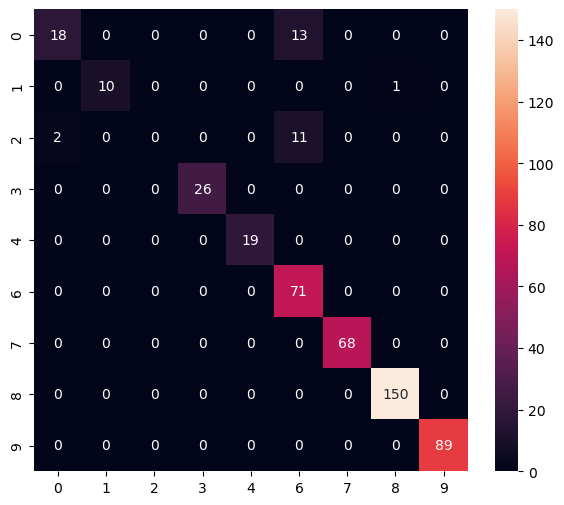

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.58      0.71        31
           1       1.00      0.91      0.95        11
           2       0.00      0.00      0.00        13
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        19
           6       0.75      1.00      0.86        71
           7       1.00      1.00      1.00        68
           8       0.99      1.00      1.00       150
           9       1.00      1.00      1.00        89

    accuracy                           0.94       478
   macro avg       0.85      0.83      0.83       478
weighted avg       0.93      0.94      0.93       478



/home/gblake/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gblake/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gblake/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [16]:

# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp45dgmjhy/assets


2022-11-15 14:10:09.383123: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-15 14:10:09.383153: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-15 14:10:09.383762: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp45dgmjhy
2022-11-15 14:10:09.385018: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-15 14:10:09.385044: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp45dgmjhy
2022-11-15 14:10:09.388980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-15 14:10:09.390057: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-15 14:10:09.428510: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp45dgmjhy
2022-11

6808